In [65]:
from deepbifurcation.coefficientSpanningDimension import AutoEncoder
import torch
import matplotlib.pylab as py
from torch import nn
from torch.autograd import grad
import numpy as np
import torchvision.models as models
import dataset
import pickle
import random

In [66]:
name = 'shufflenet_v2_x1_0'
# name = 'alexnet'

disable_cuda = 'no'
numRows = 3
numCols = 3
numJ = 2
thetaStartIndex = 0
thetaEndIndex = -1
seed = 1234
pretrained = False
database = 'sqlite:////home/rcpaffenroth/data/mydatabase.db'

In [67]:
if disable_cuda == 'no' and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cpu')

In [68]:
savedData = {}
savedData['name'] = name
savedData['disable_cuda'] = disable_cuda
savedData['numRows'] = numRows
savedData['numCols'] = numCols
savedData['numJ'] = numJ
savedData['thetaStartIndex'] = thetaStartIndex
savedData['thetaEndIndex'] = thetaEndIndex
savedData['seed'] = seed
savedData['pretrained'] = pretrained
savedData['database'] = database

In [69]:
np.random.seed(seed)
torch.manual_seed(seed)

In [70]:
if name == 'alexnet':
    bigModel = models.alexnet(pretrained=pretrained)
elif name == 'vgg11':
    bigModel = models.vgg11(pretrained=pretrained)
elif name == 'vgg13':
    bigModel = models.vgg13(pretrained=pretrained)
elif name == 'vgg16':
    bigModel = models.vgg16(pretrained=pretrained)
elif name == 'vgg19':
    bigModel = models.vgg19(pretrained=pretrained)
elif name == 'resnet18':
    bigModel = models.resnet18(pretrained=pretrained)
elif name == 'resnet34':
    bigModel = models.resnet34(pretrained=pretrained)
elif name == 'resnet50':
    bigModel = models.resnet50(pretrained=pretrained)
elif name == 'resnet101':
    bigModel = models.resnet101(pretrained=pretrained)
elif name == 'resnet152':
    bigModel = models.resnet152(pretrained=pretrained)
elif name == 'squeezenet1_0':
    bigModel = models.squeezenet1_0(pretrained=pretrained)
elif name == 'squeezenet1_1':
    bigModel = models.squeezenet1_1(pretrained=pretrained)
elif name == 'densenet121':
    bigModel = models.densenet121(pretrained=pretrained)
elif name == 'densenet169':
    bigModel = models.densenet169(pretrained=pretrained)
elif name == 'densenet161':
    bigModel = models.densenet161(pretrained=pretrained)
elif name == 'densenet201':
    bigModel = models.densenet201(pretrained=pretrained)
# elif name == 'inception_v3':
#     bigModel = models.inception_v3(pretrained=pretrained)
# elif name == 'googlenet':
#     bigModel = models.googlenet(pretrained=pretrained)
# elif name == 'shufflenet_v2_x0_5':
#     bigModel = models.shufflenet_v2_x0_5(pretrained=pretrained)
elif name == 'shufflenet_v2_x1_0':
    bigModel = models.shufflenet_v2_x1_0(pretrained=pretrained)
# elif name == 'shufflenet_v2_x1_5:
#     bigModel = models.shufflenet_v2_x1_5(pretrained=pretrained)
# elif name == 'shufflenet_v2_x2_0':
#     bigModel = models.shufflenet_v2_x2_0(pretrained=pretrained)
elif name == 'mobilenet_v2':
    bigModel = models.mobilenet_v2(pretrained=pretrained)
elif name == 'resnext50_32x4d':
    bigModel = models.resnext50_32x4d(pretrained=pretrained)
elif name == 'resnext101_32x8d':
    bigModel = models.resnext101_32x8d(pretrained=pretrained)
# elif name == 'wide_resnet502':
#     bigModel = models.wide_resnet50_2(pretrained=pretrained)
# elif name == 'wide_resnet1012':
#     bigModel = models.wide_resnet101_2(pretrained=pretrained)
# elif name == 'mnasnet0_5':
#     bigModel = models.mnasnet0_5(pretrained=pretrained)
# elif name == 'mnasnet0_75':
#     bigModel = models.mnasnet0_75(pretrained=pretrained)
# elif name == 'mnasnet_1.0':
#     bigModel = models.mnasnet1_0(pretrained=pretrained)
# elif name == 'mnasnet1_3':
#     bigModel = models.mnasnet1_3(pretrained=pretrained)
else:
    assert False,'unknown name %s'%name 

In [71]:
# bigModel

Turn off dropout

In [72]:
bigModel = bigModel.eval()

In [73]:
bigModel = bigModel.to(device=device)

In [74]:
def getParameter(k, flattenedThetaGrads):
    total = 0
    for i in range(len(flattenedThetaGrads)):
        newSize = len(flattenedThetaGrads[i])
        if total <= k and k < total+newSize:
            idx = (i, k-total)
            break
        else:
            total += newSize
    return flattenedThetaGrads[idx[0]][idx[1]]

In [75]:
class ModelWrapper(nn.Module):
    """This flattens the input and parameters of a Neural Metwork"""
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model=model
    
        # This is some code for easily accessing individual paramters
        self.flattenedParams_ = []
        self.numParameters_ = 0
        for i,t in enumerate(self.model.parameters()):
            # This makes the tensor 1D no matter What the original dimension is
            tFlat = t.view(-1)
            self.numParameters_ += len(tFlat)
            # Keep the flattened view
            self.flattenedParams_ += [tFlat]
    
    def forward(self, x):
        """This call takes the flattend input and makes it the correct shape for the model"""
        return self.model(x.view([-1,3,224,224]))
        
    def numParameters(self):
        return self.numParameters_
    
    def kToIdxPair_(self, k):
        total = 0
        for i in range(len(self.flattenedParams_)):
            neWSize = len(self.flattenedParams_[i])
            if total <= k and k < total+neWSize:
                return(i, k-total)
            else:
                total += neWSize
    
    def getParameter(self, k):
        idx = self.kToIdxPair_(k)
        return self.flattenedParams_[idx[0]][idx[1]]
    
    def setParameter(self, k, x):
        idx = self.kToIdxPair_(k)
        self.flattenedParams_[idx[0]][idx[1]] = x



In [76]:
bigModel = ModelWrapper(bigModel)

In [77]:
bigModel = bigModel.to(device=device)

In [78]:
# for p in bigModel.parameters():
#     print(torch.sum(p))

In [79]:
def loss(x):
    return torch.sum(bigModel(x)**2)

In [80]:
if pretrained:
    x = torch.zeros([1, 3*224*224], requires_grad=True, device=device)
else:
    x = torch.rand([1, 3*224*224], requires_grad=True, device=device)

In [91]:
len(bigModel(x)[0])

1000

Here is the idea to do this efficiently, getting as many entries of the Jacobian as possible With as feW calls to grad as possible.

First, do a grad With respect to the parameters $W$.  This Will give all of the roWs, and is a good place to start since the size of $W$ is often much larger than the size of $x$, so We get it out of the Way before the graph gets complex.

FIXME: We get rid of the last one, since it does not seem to have a grad function!?

In [81]:
thetaGrads = grad(loss(x), bigModel.parameters(), create_graph=True)[:-2]

In [82]:
# for t in thetaGrads:
#     print(torch.sum(t))

Now we can pick some rows

In [83]:
flattenedThetaGrads = []
numTheta = 0
for theta in thetaGrads:
    # This makes the tensor 1D no matter what the original dimension is
    tFlat = theta.view(-1)
    numTheta += len(tFlat)
    # Keep the flattened view
    flattenedThetaGrads += [tFlat]

In [84]:
# flattenedThetaGrads

In [85]:
savedData['numTheta'] = numTheta

Pick some random theta indices

In [86]:
numTheta

1253604

The Jacobian.  Rows are derivative of parameters of $f$ and columns are derivatives of the input $x$ of $f$.  Note, the parameters derivatives are always first order (Which is What makes this a Jacobian) but the derivatives With respect to $x$ can be of arbitrary order and thereby get different terms of the Taylor expansion.

$$
\begin{bmatrix}
f_\theta(x_0, x_1) \bigr\rvert_{(0,0)} \frac{\partial}{\partial \theta_1} &
\frac{\partial f_\theta(x_0, x_1)}{\partial x_0} \bigr\rvert_{(0,0)} \frac{\partial}{\partial \theta_1} &
\cdots &
\frac{\partial f_\theta(x_0, x_1)}{\partial x_1^k x_2^l} \bigr\rvert_{(0,0)} \frac{1}{k! l!} \frac{\partial}{\partial \theta_1}\\ 
f_\theta(x_0, x_1) \bigr\rvert_{(0,0)} \frac{\partial}{\partial \theta_2} &
\frac{\partial f_\theta(x_0, x_1)}{\partial x_0} \bigr\rvert_{(0,0)} \frac{\partial}{\partial \theta_2} &
\cdots &
\frac{\partial f_\theta(x_0, x_1)}{\partial x_1^k x_2^l} \bigr\rvert_{(0,0)} \frac{1}{k! l!} \frac{\partial}{\partial \theta_2}\\
\vdots & \vdots & \ddots & \vdots\\
f_\theta(x_0, x_1) \bigr\rvert_{(0,0)} \frac{\partial}{\partial \theta_m} &
\frac{\partial f_\theta(x_0, x_1)}{\partial x_0} \bigr\rvert_{(0,0)} \frac{\partial}{\partial \theta_m}&
\cdots &
\frac{\partial f_\theta(x_0, x_1)}{\partial x_0^k x_1^l} \bigr\rvert_{(0,0)} \frac{1}{k! l!} \frac{\partial}{\partial \theta_m}\\
\end{bmatrix}
$$

get the corresponding columns by taking derivatives with respect to $x$.

Pick some random x indices

In [87]:
Js = []
idxXs = []
idxThetaGrads = []
for k in range(numJ):
    idxX = np.random.permutation(range(len(x[0])))
    idxXs += [idxX]
    idxThetaGrad = random.sample(range(numTheta)[thetaStartIndex:thetaEndIndex], 
                                  numRows) 
    idxThetaGrads += [idxThetaGrad]
    J = torch.zeros([numRows,numCols])
    for i in range(numRows):
        xGrads = grad(getParameter(idxThetaGrad[i], flattenedThetaGrads), x, retain_graph=True)
        J[i, :] = xGrads[0][0][idxX[:numCols]]
    Js += [J.detach().numpy()]
savedData['idxXs']=str(idxXs)
savedData['idxThetaGrads']=str(idxThetaGrads)
#print(idxThetaGrads)

we now have some Jacobians

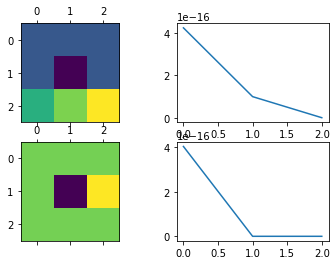

In [51]:
_,ax = py.subplots(ncols=2,nrows=len(Js))
Es = []
for i,J in enumerate(Js):
    ax[i,0].matshow(J)
    U,E,V = np.linalg.svd(J)
    ax[i,1].plot(E)
    Es += [E]

In [52]:
savedData['Js'] = pickle.dumps(Js)
savedData['Es'] = pickle.dumps(Es)

In [53]:
db = dataset.connect(database)
table = db['runs']
table.insert(savedData)

37

In [54]:
Js[0]

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 4.1399685e-22, -1.2010966e-16, -2.0414143e-22],
       [ 1.5412919e-16,  2.2864694e-16,  3.1392441e-16]], dtype=float32)